In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

Using TensorFlow backend.


In [2]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [3]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            #if i==0:
            #    print("random")
            #    np.random.shuffle(annotation_lines)
            print(annotation_lines[i])
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [4]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )



In [5]:
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

batch_size = 1

image = {}
box = {}
train_logits = {}
model_logits = {}

datagen = data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model)

D:\python\YOLO-Collection\yolov3-keras/VOCdevkit/VOC2007/JPEGImages/000012.jpg 156,97,351,270,6



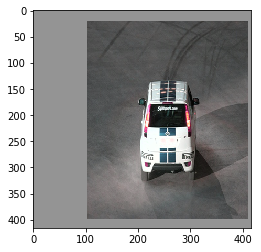

In [6]:
img,box_data,flogits,mlogits = next(datagen)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(img[0])
plt.show()

In [7]:
arrpl = flogits[0]
boxl = np.where(arrpl[...,4] > 0 )
boxl = np.transpose(boxl)
boxl

array([[0, 7, 8, 1]], dtype=int64)

In [8]:
box_data.shape

(1, 20, 5)

In [9]:
def numpy_yolo_head( pred_raw , anchors_m , input_shape ):                                                    
    anchors_tensor = np.reshape( anchors_m , [1, 1, 1, len( anchors_m ) , 2] )

    grid_shape = pred_raw.shape[1:3] # height, width
    grid_shape
    grid_y = np.tile(np.reshape(np.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = np.tile(np.reshape(np.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = np.concatenate([grid_x, grid_y],axis=-1)

    #print(l)
    pred_xy = (sigmoid(pred_raw [...,:2]) + grid ) / np.array( grid_shape[::-1] )
    pred_wh = np.exp(pred_raw [..., 2:4]) * anchors_tensor  / np.array( input_shape[::-1] )
    pred_conf = sigmoid(pred_raw[..., 4:5])
    pred_class = sigmoid(pred_raw[..., 5:])

    return pred_xy, pred_wh , pred_conf , pred_class


In [10]:
def numpy_box_iou(b1, b2):
    # Expand dim to apply broadcasting.
    b1 = np.expand_dims(b1, -2)
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh/2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half

    # Expand dim to apply broadcasting.
    b2 = np.expand_dims(b2, 0)
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    intersect_mins = np.maximum(b1_mins, b2_mins)
    intersect_maxes = np.minimum(b1_maxes, b2_maxes)
    intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    iou = intersect_area / (b1_area + b2_area - intersect_area)

    return iou

In [11]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap  

In [12]:
def sigmoid(x):
        """sigmoid.

        # Arguments
            x: Tensor.

        # Returns
            numpy ndarray.
        """
        return 1 / (1 + np.exp(-x))

In [13]:
mlogits[2].shape

(1, 52, 52, 3, 25)

## loop this every scale

Prepare Prediction

In [14]:
l=0

In [38]:
num_layers = len(anchors)//3 # default setting
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

pred_xy, pred_wh , pred_conf , pred_class = numpy_yolo_head( mlogits[l] ,anchors[anchor_mask[l]], input_shape )
pred_detect = np.concatenate([pred_xy, pred_wh , pred_conf , pred_class ],axis=-1)
pred_box = np.concatenate([pred_xy, pred_wh ],axis=-1)

pred_detect.shape

(1, 13, 13, 3, 25)

In [16]:
flogits[0].shape

(1, 13, 13, 3, 25)

Value needed to measure mAP:
xywh conf class

get detection and annotation for every sclae and put them into a new array


In [53]:
all_detections  = [ [] for i in range(num_classes)]
all_annotations = [ [] for i in range(num_classes)]
#all_detections[0].append(np.array([4,53,43,43]))
#all_detections[0].append(np.array([4,53,43,43]))
#len( all_detections[0] )

In [52]:
flogits[l][0,7,8,1]

array([0.62259614, 0.5480769 , 0.28846154, 0.47115386, 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [54]:
all_detections[0].append( flogits[l][0,7,8,1]) 
all_detections[0]

[array([0.62259614, 0.5480769 , 0.28846154, 0.47115386, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32)]

In [55]:

all_detections[0][0][...,0:4].shape
pred_all = all_detections[0][0][...,0:4]
pred_all

array([0.62259614, 0.5480769 , 0.28846154, 0.47115386], dtype=float32)

In [57]:
#object_mask = all_detections[0][0][..., 4:5]
#object_mask_bool = np.array(object_mask , dtype=bool)
#true_box = all_detections[0][0][...,0:4][ object_mask_bool[...,0] ]
#print(true_box.shape)
iou = numpy_box_iou(pred_all, pred_all)
iou
#best_iou = np.max(iou, axis=-1)
#print(iou.shape)
#best_iou.shape

array([1.0000002], dtype=float32)

In [25]:
pred_box.shape

(1, 13, 13, 3, 4)

loop through the batch and scale

In [21]:
arrpl = flogits[0]
boxl = np.where(arrpl[...,4] > 0 )
boxl = np.transpose(boxl)
boxl

array([[0, 7, 6, 1]], dtype=int64)

In [69]:
arrp= arrpl
box = boxl
for i in range(len(box)):
    detection_label =  np.argmax( arrp[tuple(box[i])][5:]) 
    print( "{} = {}".format(detection_label, obj[  detection_label ] ) )
    
    annotation_label =  np.argmax( arrp[tuple(box[i])][5:]) 
    print( "{} = {}".format(annotation_label, obj[  annotation_label ] ) )
    
    all_detections[detection_label].append( pred_detect[tuple(box[i])] ) 
    all_annotations[annotation_label].append( arrp[tuple(box[i])] ) 
    

6 = car
6 = car


In [35]:
object_mask = flogits[l][..., 4:5]
object_mask_bool = np.array(object_mask , dtype=bool)
true_box = flogits[l][0,...,0:4][ object_mask_bool[0,...,0] ]
#print(true_box.shape)
iou = numpy_box_iou(pred_box, true_box)
best_iou = np.max(iou, axis=-1)
print(iou.shape)
best_iou.shape

(1, 13, 13, 3, 1)


(1, 13, 13, 3)

In [39]:
true_box.shape

(0, 4)

In [40]:
pred_box.shape

(1, 13, 13, 3, 4)

In [ ]:
me_true_box .shape

Prepare iou

In [ ]:
object_mask = flogits[l][..., 4:5]
object_mask_bool = K.cast(object_mask, 'bool')
true_box = tf.boolean_mask(flogits[l][0,...,0:4], object_mask_bool[0,...,0])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(object_mask_bool.eval().shape)
    print(true_box.eval())
#x y w h of true box    

In [ ]:
iou = box_iou(pred_box, true_box)
best_iou = K.max(iou, axis=-1)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print( iou.eval().shape )
    #iou = np.expand_dims( iou.eval() , axis=0)
    #print(iou.shape)
    #print( best_iou.eval().shape )
    #best_iou = np.expand_dims( best_iou.eval() , axis=0)
    best_iou = best_iou.eval()
    print(best_iou.shape)
   

evaluate with label

In [48]:
arrpl = flogits[l]
boxl = np.where(arrpl[...,4] > 0 )
boxl = np.transpose(boxl)
boxl

array([[0, 7, 8, 1]], dtype=int64)

In [ ]:
iou_thres = 0.5
conf_thres = 0.5

false_positives = np.zeros((0,))
true_positives  = np.zeros((0,))
scores          = np.zeros((0,))

arrp= arrpl
box = boxl
for i in range(len(box)):
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( pred_box[ tuple(box[i]) ] )
    print( pred_conf[ tuple(box[i]) ] )
    print( pred_class[ tuple(box[i]) ] )
    pred_label =  np.argmax( pred_class[tuple(box[i])]) 
    print( "{} = {}".format(pred_label, obj[ pred_label] ) )
    print("-------------------------------------------------------")
    scores = np.append(scores, pred_conf[ tuple(box[i]) ] )
    if( best_iou[tuple(box[i])] > iou_thres and  pred_conf[tuple(box[i])] > conf_thres and (true_label and pred_label) ):
        #print( best_iou[tuple(box[i])] )
        false_positives = np.append(false_positives, 0)
        true_positives   = np.append(true_positives, 1)
    else:
        false_positives = np.append(false_positives, 1)
        true_positives  = np.append(true_positives, 0)
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    

In [ ]:
arrpl = flogits[1]
boxl = np.where(arrpl[...,4] > 0 )
boxl = np.transpose(boxl)
boxl

In [ ]:
true_positives

In [ ]:
false_positives

In [ ]:
indices         = np.argsort(-scores)
false_positives = false_positives[indices]
true_positives  = true_positives[indices]

In [ ]:
true_positives

In [ ]:
false_positives = np.cumsum(false_positives)
true_positives  = np.cumsum(true_positives)

In [ ]:
true_positives 

In [ ]:
recall = true_positives  / len(box)
recall

In [ ]:
precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
precision

In [ ]:
np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

In [ ]:
average_precision  = compute_ap(recall, precision)
average_precision

In [ ]:
true_positives = np.array( [1,1,0] )
print( true_positives )
true_positives  = np.cumsum(true_positives)
print( true_positives )

false_positives = np.array( [0,0,1] )
print( false_positives )

false_positives = np.cumsum(false_positives)
print( false_positives )


recall = true_positives  / 3
print( recall )

precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
print( precision )

average_precision  = compute_ap(recall, precision)
print( average_precision )